<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/analysis/08_AESurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install torchtuples

     |████████████████████████████████| 51kB 3.6MB/s 


In [4]:
! pip install pycox

     |████████████████████████████████| 81kB 3.9MB/s 


In [37]:
import numpy as np
import feather
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import torchtuples as tt

from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

import os

In [6]:
# random
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [7]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_features),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
        )

        # Full connection
        self.survnet = nn.Sequential(
            nn.Linear(encoded_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.survnet(encoded)
        return phi, decoded

    def predict(self, input):
        encoded = self.encoder(input)
        return self.survnet(encoded)


In [8]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), "Need `alpha` in [0, 1]."
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()

    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae


In [9]:
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    return (df["duration"].values, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
filepath="/content/drive/MyDrive/colab-data/total416.os.se.norm.feather"

In [21]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [22]:
# make train and validation datasets with tuplefy
train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

In [48]:
durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

In [23]:
# set arch
in_features = x_train.shape[1]
encoded_features = 64
out_features = labtrans.out_features
netaesurv = NetAESurv(in_features, encoded_features, out_features)

In [25]:
netaesurv

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=6636, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=6636, bias=True)
  )
  (survnet): Sequ

In [26]:
# loss
loss = LossAELogHaz(0.6)

In [27]:
loss

LossAELogHaz(
  (loss_surv): NLLLogistiHazardLoss()
  (loss_ae): MSELoss()
)

In [28]:
# model
model = LogisticHazard(net=netaesurv, optimizer=tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

In [29]:
# metrics
metrics = dict(loss_surv=LossAELogHaz(1), loss_ae=LossAELogHaz(0))

# callbacks
callbacks = [tt.cb.EarlyStopping()]

# cycling
batch_size = 5
epochs = 10

# trainning model
log = model.fit(
    *train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=False, val_data=val, metrics=metrics
)

In [30]:
res = model.log.to_pandas()

In [31]:
res.head()

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
0,573.249661,1.801545,1430.421796,7.146252,1.345153,15.847899
1,2642.817926,1.627021,6604.604241,6.252069,1.500744,13.379058
2,641.775984,1.235720,1602.586351,1.060756,1.173237,0.892035
3,1.037499,1.046423,1.024112,1.082985,1.234968,0.855010
4,1.034279,1.050387,1.010116,1.088290,1.247630,0.849281


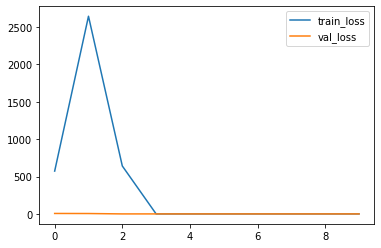

In [32]:
_ = res[['train_loss', 'val_loss']].plot()

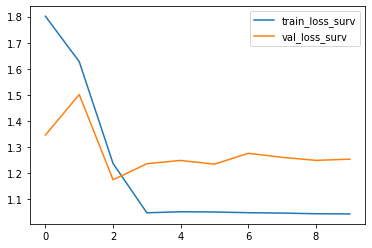

In [33]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

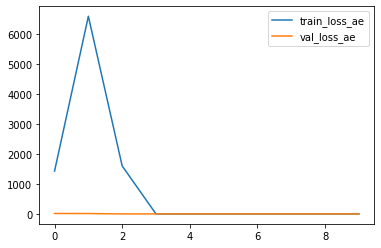

In [34]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

In [43]:
surv1 = model.interpolate(10).predict_surv_df(x_test1)
surv2 = model.interpolate(10).predict_surv_df(x_test2)

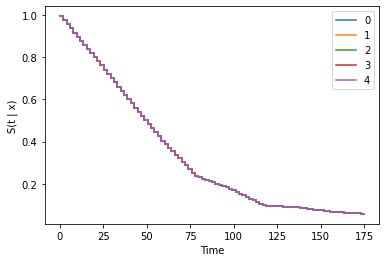

In [44]:
surv1.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [45]:
model.predict(x_test1[:2])

array([[-4.9734654 , -1.4247272 , -1.093073  , -0.73116386, -0.33743498,
        -1.0878025 , -0.22108015, -2.2338657 , -1.1517677 , -1.7567525 ],
       [-4.9734654 , -1.4247272 , -1.093073  , -0.73116386, -0.33743498,
        -1.0878025 , -0.22108015, -2.2338657 , -1.1517677 , -1.7567525 ]],
      dtype=float32)

In [46]:
model.predict_net(x_test1[:2])

(array([[-4.9734654 , -1.4247272 , -1.093073  , -0.73116386, -0.33743498,
         -1.0878025 , -0.22108015, -2.2338657 , -1.1517677 , -1.7567525 ],
        [-4.9734654 , -1.4247272 , -1.093073  , -0.73116386, -0.33743498,
         -1.0878025 , -0.22108015, -2.2338657 , -1.1517677 , -1.7567525 ]],
       dtype=float32),
 array([[-0.24762058, -0.20129874,  0.19890971, ..., -0.21481007,
         -0.14949104, -0.17779917],
        [-0.24762058, -0.20129874,  0.19890971, ..., -0.21481007,
         -0.14949104, -0.17779917]], dtype=float32))

In [49]:
evs1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
evs2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')

In [50]:
evs1.concordance_td('antolini')

0.0

In [51]:
evs2.concordance_td('antolini')

0.0

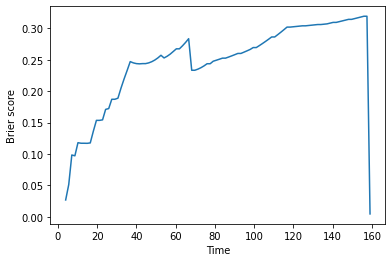

In [52]:
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
evs1.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

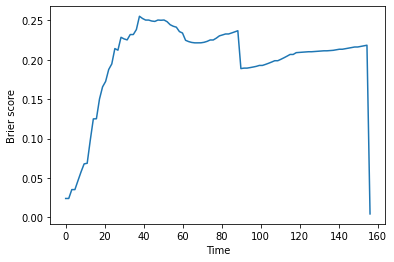

In [53]:
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 100)
evs2.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

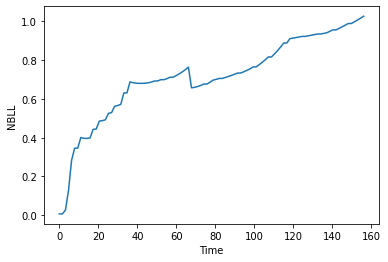

In [54]:
evs1.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

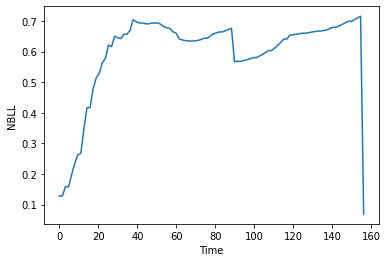

In [55]:
evs2.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [56]:
evs1.integrated_brier_score(time_grid)

0.24157056596658527

In [57]:
evs1.integrated_nbll(time_grid)

0.7115625772712758

In [58]:
evs2.integrated_brier_score(time_grid)

0.2001652170449665

In [59]:
evs2.integrated_nbll(time_grid)

0.6009230711429385